In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [10]:
df = pd.read_csv('ETTh1.csv')
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [11]:
df.shape

(17420, 8)

In [12]:
missing_values = df.isnull().sum()
print(missing_values)

date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64


In [14]:
scaler = StandardScaler()
scale_df = scaler.fit_transform(df.iloc[:, 1:])
scale_df = pd.DataFrame(scale_df, columns=df.columns[1:])
scale_df.insert(0, 'date', df['date'])
scale_df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,-0.219049,-0.114207,-0.395683,-0.231903,0.976355,0.805738,2.008513
1,2016-07-01 01:00:00,-0.238009,-0.081400,-0.411356,-0.251800,0.923970,0.857445,1.688203
2,2016-07-01 02:00:00,-0.313849,-0.245432,-0.442557,-0.291043,0.610524,0.602247,1.688203
3,2016-07-01 03:00:00,-0.323329,-0.147013,-0.442557,-0.271146,0.636286,0.703993,1.368010
4,2016-07-01 04:00:00,-0.285409,-0.147013,-0.411356,-0.231903,0.688671,0.703993,1.006610


In [17]:
T = 336
H = 24

def create_data(df, T, H):
    X, y = [], []
    for i in range(T, len(df) - H):
        X.append(df.iloc[i-T:i, 1:].values) 
        y.append(df.iloc[i:i+H, -1].values)
    return np.array(X), np.array(y)

X, y = create_data(scale_df, T, H)

In [18]:
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 50
num_layers = 2
output_size = H


Epoch [1/20], Loss: 0.0982
Epoch [2/20], Loss: 0.0856
Epoch [3/20], Loss: 0.0926
Epoch [4/20], Loss: 0.0763
Epoch [5/20], Loss: 0.0611
Epoch [6/20], Loss: 0.0877
Epoch [7/20], Loss: 0.0638
Epoch [8/20], Loss: 0.0938
Epoch [9/20], Loss: 0.0901
Epoch [10/20], Loss: 0.0590
Epoch [11/20], Loss: 0.0468
Epoch [12/20], Loss: 0.0579
Epoch [13/20], Loss: 0.0837
Epoch [14/20], Loss: 0.0525
Epoch [15/20], Loss: 0.0496
Epoch [16/20], Loss: 0.0419
Epoch [17/20], Loss: 0.0360
Epoch [18/20], Loss: 0.0577
Epoch [19/20], Loss: 0.0455
Epoch [20/20], Loss: 0.0404
Mean Squared Error: 0.09866633010494831


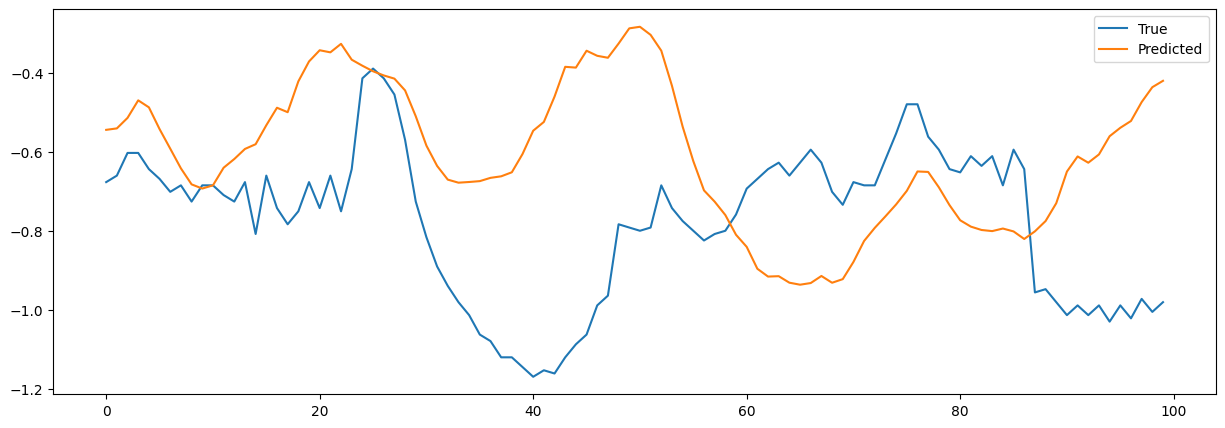

In [21]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
model.train()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_pred.append(outputs.cpu().numpy())

y_pred = np.concatenate(y_pred, axis=0)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

plt.figure(figsize=(15, 5))
plt.plot(y_test[:100, -1], label='True')  
plt.plot(y_pred[:100, -1], label='Predicted')
plt.legend()
plt.show()